In [1]:
# Setup kaggle CLI
!pip install -qq kaggle
from google.colab import files
print("Upload kaggle.json file")
files.upload()
!mkdir ~/.kaggle 
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload kaggle.json file


Saving kaggle.json to kaggle.json


In [2]:
# download face masks dataset + unzip + delete zipped
!kaggle datasets download wobotintelligence/face-mask-detection-dataset
!unzip -qq face-mask-detection-dataset.zip
!rm face-mask-detection-dataset.zip

100% 2.49G/2.50G [00:36<00:00, 21.0MB/s]
100% 2.50G/2.50G [00:36<00:00, 73.6MB/s]


In [3]:
import os
base_dir = os.path.join("Medical mask", "Medical mask")
image_dir = os.path.join(base_dir, "Medical Mask", "images")
annotation_dir = os.path.join(base_dir, "Medical Mask", "annotations")

In [4]:
import pandas as pd
df = pd.read_csv("train.csv")
display(df.head)
df['classname'].value_counts()

<bound method NDFrame.head of            name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
2      2756.png   75  252  264  390   mask_colorful
3      2756.png  521  136  711  277   mask_colorful
4      6098.jpg  360   85  728  653    face_no_mask
...         ...  ...  ...  ...  ...             ...
15407  1894.jpg  437  121  907  644  face_with_mask
15408  1894.jpg  557  363  876  636   mask_surgical
15409  1894.jpg  411    3  940  325             hat
15410  3216.png  126   69  409  463  face_with_mask
15411  3216.png  136  289  393  461   mask_colorful

[15412 rows x 6 columns]>

face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64

In [5]:
# get only face with mask and face without mask images and reset dataframe index
df = df[ (df['classname'] == 'face_with_mask') | (df['classname'] == 'face_no_mask') ]
df.reset_index(inplace=True, drop=True)
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,6098.jpg,360,85,728,653,face_no_mask
3,4591.png,239,9,522,342,face_with_mask
4,5525.jpg,262,18,484,319,face_no_mask


In [6]:
df['classname'].value_counts()

face_with_mask    4180
face_no_mask      1569
Name: classname, dtype: int64

In [7]:
# shuffle dataframe rows before undersampling
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
# Undersampling to get both classes to 1569 images each
df2 = df.copy()
mask_count = df['classname'].value_counts()['face_with_mask']
threshold = df['classname'].value_counts()['face_no_mask']
for idx in range(len(df2)):
  if mask_count > threshold and df2.iloc[idx]['classname'] == "face_with_mask":
    df.drop(index=idx, inplace=True)
    mask_count -= 1

df['classname'].value_counts()

face_no_mask      1569
face_with_mask    1569
Name: classname, dtype: int64

In [9]:
# reshuffle again to get uniform distribution of each class
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,name,x1,x2,y1,y2,classname
0,4096.png,24,22,150,180,face_with_mask
1,4310.png,0,0,40,36,face_no_mask
2,5151.jpg,112,123,141,158,face_no_mask
3,4216.png,242,35,417,299,face_with_mask
4,4219.png,127,126,178,197,face_with_mask


In [10]:
def getImageDir(image_name):
  return os.path.join(image_dir, image_name)

In [11]:
import numpy as np

# returns image bounding box in the form (x1, x2, y1, y2)
def getImageBoxesAndLabels(image_name):
  image_row = df.loc[df['name'] == image_name]
  boxes = []
  labels = list(image_row['classname'])
  for idx in range(len(image_row)):
    x1 = list(image_row['x1'])[idx]
    y1 = list(image_row['x2'])[idx]
    x2 = list(image_row['y1'])[idx]
    y2 = list(image_row['y2'])[idx]
    # x2 and y1 were swapped in the df so we reswap them
    box = [x1, x2, y1, y2]
    boxes.append(box) 
  return [boxes, labels]

getImageBoxesAndLabels(df['name'][5])

[[[56, 342, 3, 298], [418, 719, 89, 608]],
 ['face_with_mask', 'face_with_mask']]

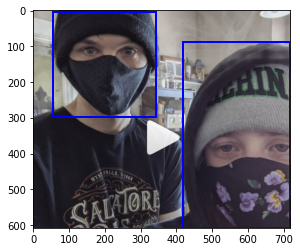

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

def showImageBoxes(image_name):
  fig, ax = plt.subplots()
  boxes, labels = getImageBoxesAndLabels(image_name)
  im = np.asarray(Image.open(getImageDir(image_name)))
  ax.imshow(im)
  for box in boxes:
    rect = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2, edgecolor="blue", fill=False)
    ax.add_patch(rect)
  fig.show()

showImageBoxes(df['name'][5])

(295, 286, 3)


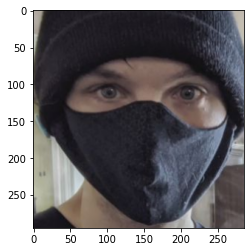

In [13]:
def getImageCroppedData(image_name):
  boxes, labels = getImageBoxesAndLabels(image_name)
  im = np.array(Image.open(getImageDir(image_name)))
  faces = []
  for box in boxes:
    face = im[box[2]:box[3], box[0]:box[1]]
    faces.append(face)
  # print(image_name)
  return faces

print(getImageCroppedData(df['name'][5])[0].shape)
plt.imshow(getImageCroppedData(df['name'][5])[0])

In [14]:
# make dirs for each - train, test, val and mask/no mask for each
dirs = ["Train", "Test", "Train/mask", "Train/no_mask", "Test/mask", "Test/no_mask"]
for dir in dirs:
  os.mkdir(dir)

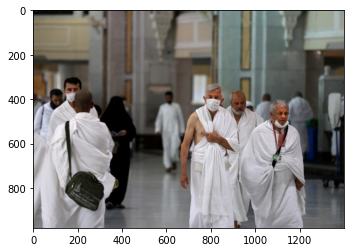

In [15]:
plt.imshow(plt.imread(getImageDir("0012.jpg")))

In [16]:
target_size = (256, 256, 3)
def saveCroppedFaces(image_name):
  boxes, labels = getImageBoxesAndLabels(image_name)
  cropped_arr = getImageCroppedData(image_name)
  # 85-15 train test split?
  idx = np.random.random()
  if idx > 0.85:
    split = "Test"
  else:
    split = "Train"
  
  for i, (face, label) in enumerate(zip(cropped_arr, labels)):
    if label == "face_with_mask":
      label = "mask"
    else:
      label = "no_mask"
    im = Image.fromarray(face).resize(target_size[:2])
    image_path = os.path.join(split, label, image_name.split(".")[0]+"N"+str(i)+".png")
    im.save(image_path)

In [17]:
# sort cropped faces into correct mask/no_mask dirs
for idx, image_name in enumerate(df['name']):
  saveCroppedFaces(image_name)
  # lazy progress bar
  if idx%100==0:
    print(idx/len(df))

0.0
0.03186743148502231
0.06373486297004462
0.09560229445506692
0.12746972594008923
0.15933715742511154
0.19120458891013384
0.22307202039515614
0.25493945188017847
0.28680688336520077
0.3186743148502231
0.3505417463352454
0.3824091778202677
0.41427660930529
0.4461440407903123
0.4780114722753346
0.5098789037603569
0.5417463352453792
0.5736137667304015
0.6054811982154238
0.6373486297004461
0.6692160611854685
0.7010834926704907
0.7329509241555131
0.7648183556405354
0.7966857871255577
0.82855321861058
0.8604206500956023
0.8922880815806246
0.9241555130656469
0.9560229445506692
0.9878903760356915


In [18]:
# # Don't uncomment and run this unless you wanna undo all the progress of the previous cell
# !rm -r Test/
# !rm -r Train/
# !rm -r Val/

In [19]:
print("Train/mask", len(os.listdir("Train/mask")))
print("Train/no_mask", len(os.listdir("Train/no_mask")))
print("Test/mask", len(os.listdir("Test/mask")))
print("Test/no_mask", len(os.listdir("Test/no_mask")))

Train/mask 1417
Train/no_mask 1472
Test/mask 376
Test/no_mask 538


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    # shuffle=False
)

In [21]:
target_size = (256, 256, 3)
train_generator = train_datagen.flow_from_directory(
        'Train',
        target_size=target_size[:2],
        class_mode='binary',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        'Train',
        target_size=target_size[:2],
        class_mode='binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
    'Test',
    target_size=target_size[:2],
    class_mode='binary'
)

Found 2312 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
Found 914 images belonging to 2 classes.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalMaxPooling2D

In [23]:
# try efficientnet architecture
!pip install keras_efficientnets
!pip install keras_applications

     |████████████████████████████████| 51kB 2.6MB/s 


In [24]:
import keras_efficientnets

In [25]:
model = Sequential([
  keras_efficientnets.EfficientNetB0(
    input_shape=target_size,
    weights='imagenet',
    include_top=False),
    GlobalMaxPooling2D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])
# model=Sequential([
#   Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=target_size),
# Conv2D(32, (3, 3), activation='relu'),
# Conv2D(32, (3, 3), activation='relu'),
# MaxPooling2D((2, 2)),
# # Dropout(0.25),

# Conv2D(64, (3, 3), activation='relu'),
# Conv2D(64, (3, 3), activation='relu'),
# Conv2D(64, (3, 3), activation='relu'),
# MaxPooling2D((2, 2)),
# # Dropout(0.25),

# # Conv2D(128, (3, 3), activation='relu'),
# # Conv2D(128, (3, 3), activation='relu'),
# # Conv2D(128, (3, 3), activation='relu'),
# # MaxPooling2D((2, 2)),
# # # Dropout(0.25),

# Flatten(),
# Dropout(0.5),
# Dense(50, activation='relu'),
# Dropout(0.5),
# Dense(1, activation='sigmoid')
# ])

16719872/16717576 [==============================] - 1s 0us/step


In [26]:
import tensorflow as tf

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 8, 8, 1280)        4049564   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,090,589
Trainable params: 4,048,573
Non-trainable params: 42,016
_________________________________________

In [27]:
batch_size = 32
history = model.fit(train_generator,
          batch_size=batch_size,
          epochs=5,
          steps_per_epoch = train_generator.samples // batch_size,
          validation_steps = val_generator.samples // batch_size,
          validation_data=val_generator,
          callbacks=[early_stopper])

Epoch 1/5
72/72 [==============================] - 54s 755ms/step - loss: 0.6830 - accuracy: 0.8276 - val_loss: 0.1912 - val_accuracy: 0.9184
Epoch 2/5
72/72 [==============================] - 53s 732ms/step - loss: 0.0938 - accuracy: 0.9658 - val_loss: 0.1165 - val_accuracy: 0.9757
Epoch 3/5
72/72 [==============================] - 52s 728ms/step - loss: 0.0769 - accuracy: 0.9789 - val_loss: 0.2563 - val_accuracy: 0.9549
Epoch 4/5
72/72 [==============================] - 52s 724ms/step - loss: 0.0635 - accuracy: 0.9711 - val_loss: 0.3275 - val_accuracy: 0.9722
Epoch 5/5
72/72 [==============================] - 52s 725ms/step - loss: 0.0405 - accuracy: 0.9842 - val_loss: 0.2159 - val_accuracy: 0.9670


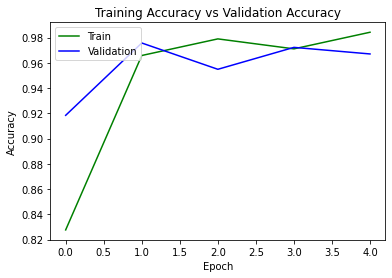

In [28]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

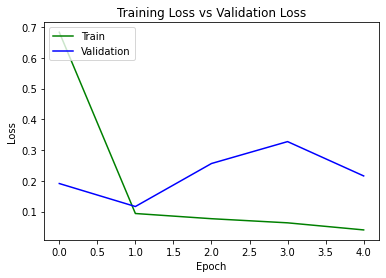

In [29]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
model.evaluate(test_generator)

29/29 [==============================] - 4s 131ms/step - loss: 0.0450 - accuracy: 0.9803


[0.045031871646642685, 0.9803063273429871]

In [ ]:
model.save("256x256_MaskDetector_9860.h5")

In [ ]:
from keras.models import load_model
model = load_model("256x256_MaskDetector_9860.h5")

In [31]:
model.evaluate(train_generator)
model.evaluate(val_generator)
model.evaluate(test_generator)

29/29 [==============================] - 4s 122ms/step - loss: 0.0450 - accuracy: 0.9803


[0.04503187537193298, 0.9803063273429871]

In [32]:
# load in mtcnn so we can get bounding boxes and mask predictions for test images
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.4MB/s 


In [33]:
import mtcnn
face_detector = mtcnn.MTCNN()

[{'box': [554, 170, 127, 162], 'confidence': 0.9999903440475464, 'keypoints': {'left_eye': (589, 238), 'right_eye': (647, 230), 'nose': (625, 274), 'mouth_left': (607, 306), 'mouth_right': (651, 297)}}, {'box': [400, 372, 115, 139], 'confidence': 0.9999566078186035, 'keypoints': {'left_eye': (435, 429), 'right_eye': (491, 424), 'nose': (465, 461), 'mouth_left': (445, 479), 'mouth_right': (486, 478)}}, {'box': [785, 257, 142, 173], 'confidence': 0.999147891998291, 'keypoints': {'left_eye': (827, 325), 'right_eye': (888, 325), 'nose': (856, 357), 'mouth_left': (831, 391), 'mouth_right': (882, 393)}}, {'box': [214, 295, 124, 156], 'confidence': 0.9981188178062439, 'keypoints': {'left_eye': (248, 360), 'right_eye': (306, 351), 'nose': (278, 384), 'mouth_left': (262, 417), 'mouth_right': (304, 412)}}, {'box': [521, 113, 40, 49], 'confidence': 0.9959439635276794, 'keypoints': {'left_eye': (532, 133), 'right_eye': (551, 132), 'nose': (542, 143), 'mouth_left': (536, 152), 'mouth_right': (551, 

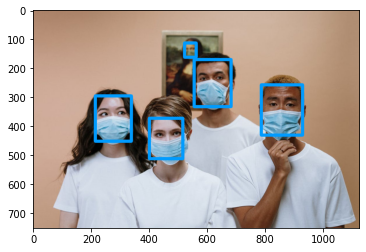

In [34]:
import cv2
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

img = plt.imread(getImageDir(test_images[2]))
faces_pred = face_detector.detect_faces(img)
print(faces_pred)
for face in faces_pred:
  box=face['box']
  x=cv2.rectangle(img,
              (box[0], box[1]),
              (box[0]+box[2], box[1] + box[3]),
              (0,155,255),
              10)
  plt.imshow(x)
plt.show()

['5459N0.png', '6013N3.png', '3353N2.png', '6266N1.png', '4625N0.png', '6100N2.png', '5939N3.png', '6150N2.png', '6029N0.png', '6392N1.png', '4645N2.png', '3181N0.png', '6282N6.png', '6267N3.png', '5493N0.png', '6031N1.png', '6288N7.png', '5133N1.png', '6000N2.png', '5989N4.png', '5120N2.png', '5979N1.png', '6052N1.png', '1922N0.png', '6232N3.png', '6185N0.png', '6228N0.png', '6018N1.png', '6228N4.png', '2935N4.png', '5989N0.png', '3549N0.png', '6253N1.png', '5371N0.png', '5298N0.png', '6282N3.png', '5593N0.png', '5919N1.png', '6197N0.png', '6236N0.png', '6228N3.png', '1940N0.png', '5113N0.png', '2310N0.png', '6310N2.png', '6104N3.png', '1991N1.png', '5943N0.png', '5985N0.png', '5949N1.png', '5938N0.png', '5321N0.png', '2935N2.png', '6000N12.png', '3181N1.png', '6209N0.png', '6015N0.png', '5858N0.png', '2499N3.png', '1914N10.png', '6007N3.png', '5911N2.png', '5672N1.png', '6137N0.png', '2499N1.png', '5298N1.png', '6288N5.png', '6364N2.png', '6310N5.png', '6284N3.png', '2537N2.png', '25

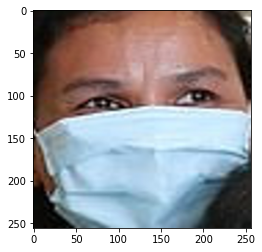

[[2.5523487e-33]]
2.5523487e-33
with_mask


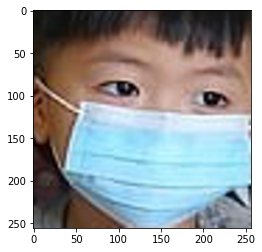

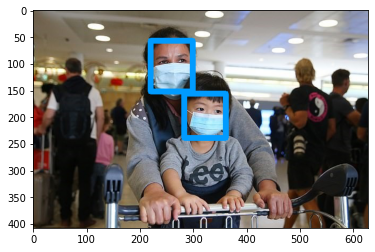

In [40]:
target_size=(256, 256, 3)
def getPredictedCrop(image_data):
  pred_crop_data = []
  faces_pred = face_detector.detect_faces(image_data)
  for face in faces_pred:
    pred_box = face['box']
    for i in range(len(pred_box)):
      if pred_box[i] < 0:
        pred_box[i] = 0
      # also add case for if x is more than width or y is more than height
    pred_box = [pred_box[0], pred_box[0]+pred_box[2], pred_box[1], pred_box[1]+pred_box[3]]
    pred_box = image_data[pred_box[2]:pred_box[3], pred_box[0]:pred_box[1]]
    pred_crop_data.append(pred_box)
  return np.array(pred_crop_data)

def predictAndShow(image_dir):
  # read in image
  img = plt.imread(image_dir)
  faces_pred = face_detector.detect_faces(img)
  print(faces_pred)
  # get mask model prediction for each crop (face)
  for pred_crop in getPredictedCrop(img):
    im = np.asarray(Image.fromarray(pred_crop).resize(target_size[:2]))/255.
    raw_pred = model.predict(np.expand_dims(im, 0))
    print(raw_pred)
    print(np.squeeze(raw_pred))
    # parse prediction
    if raw_pred[0][0] > 0.5:
      print("without_mask")
    else:
      print("with_mask")
    plt.imshow(im)
    plt.show()

    # draw predicted face bboxes
  for face in faces_pred:
    box=face['box']
    x=cv2.rectangle(img,
                (box[0], box[1]),
                (box[0]+box[2], box[1] + box[3]),
                (0,155,255),
                10)
    plt.imshow(x)
  plt.show()
  
print(os.listdir("Test/no_mask"))
print(os.listdir("Test/mask"))
predictAndShow(getImageDir("2006.jpg"))